In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:{}".format(device))

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

device:cuda


In [23]:
dff=pd.read_csv("dff.csv",header=0,index_col=0)
dff=dff.fillna(0)

In [24]:
dff1= pd.read_csv("Data_raw.csv",header=0,index_col=0)

In [25]:
dff["STR"] = dff1["STR"];

In [26]:
L=245 # 需要训练245个Reservoir
Total = 816 #总共有816个数据
#For entire sample forecasting (1997.08-2017.12)
WL=Total-L # rolling window length 训练每一个Reservoir的数据集大小 WL=windows_length
ws=0# rolling window start index ws=277 for subsample, ws=0 for entire sample

In [27]:
RV=np.array(dff['RV'],dtype=np.float32).reshape(-1,1)

In [28]:
F = ["RV", "MKT", "diff_DP", "IP", "DEF","EP","SMB","diff_TB", "HML", "INF","STR"]
features = len(F)

In [29]:
Data=np.array(dff[F],dtype=np.float32).reshape(-1,features)

In [30]:
test = dff.iloc[-245:]

In [31]:
# 超参数
input_size = features
hidden_size = 60
num_layers = 2
output_size = 1
num_epochs = 100
batch_size = 256
learning_rate = 0.001
K=3

In [32]:
# 初始化模型、损失函数和优化器
def train_model(model,train_loader):
    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

In [33]:
predictions_lstm = np.zeros((L,1))
ws=0
while ws < L:
    #每次训练前，初始化模型，优化器
    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    #构建训练数据集，（样本数，时间序列的长度（t的步数），特征数）
    x_train=torch.zeros(WL-K,K,features)
    y_train = torch.from_numpy(RV[ws+K:ws+WL])
    
    for t in range(WL-K):
        X=np.array(Data[ws+t:ws+t+K,:]).reshape(-1,features)
        x_train[t,:,:] = torch.from_numpy(X)
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    #完成训练数据收集
    model = train_model(model,train_loader) 
    #训练读出层
    
    x_test = torch.zeros(1,K,input_size).to(device)
    x_test[0,:,:]=torch.from_numpy(np.array(Data[ws+WL-K:ws+WL]).reshape(-1,features))
    
    model.eval()
    with torch.no_grad():
        predictions_lstm[ws,0] = model(x_test)
    
    ws+=1 #起始点加一0

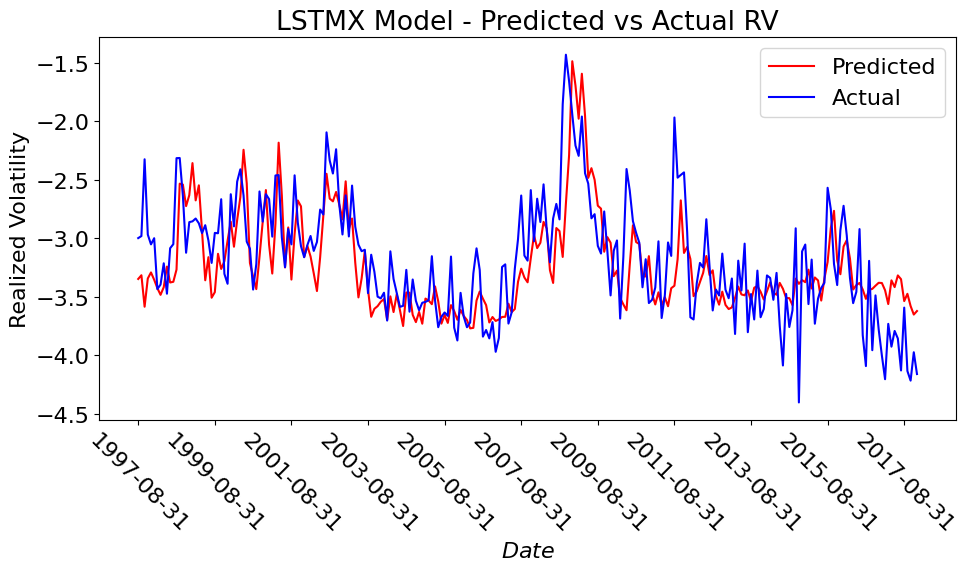

In [34]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
plt.title("LSTMX Model - Predicted vs Actual RV")
plt.xlabel("$Date$")
plt.plot(test.index,predictions_lstm, label="Predicted", color="red")
plt.plot(test.index,RV[WL:], label="Actual", color="blue")
plt.xticks(test.index[::24],rotation=-45)
plt.ylabel('Realized Volatility')
plt.tight_layout() 
plt.legend()
#plt.savefig("LSTM/lstm_model{}_{}.png".format(hidden_size,K))
plt.show()

In [35]:
def compute_qlike(forecasts, actuals):
    """
    Compute the QLIKE (Quasi-Likelihood) loss function for evaluating forecasting accuracy.
    forecasts: Forecasted variance (sigma squared from a model)
    actuals: Realized variance (actual observed variance)
    """
    # Using absolute values of forecasts and actuals
    forecasts = np.abs(forecasts)
    actuals = np.abs(actuals)

    # Calculate the ratio and ensure it's positive
    ratio = actuals / forecasts

    # Compute QLIKE
    qlike = np.sum(ratio - np.log(ratio) - 1)
    return qlike


def qlike_loss(y_true, y_hat):
  """
  This function computes the mean Quasi-Likelihood (QLIKE) loss function.

  Args:
      y_true (np.ndarray): True values of the variable.
      y_hat (np.ndarray): Predicted values of the variable.

  Returns:
      float: Mean QLIKE loss between the true and predicted values.
  """
  eps = np.finfo(float).eps  # Machine epsilon for numerical stability
  w = np.abs(y_true - y_hat) / (y_hat + eps)
  return np.mean(np.log(1 + w**2))

In [36]:
actual = RV[WL:]

In [37]:
qlike_loss_value = qlike_loss(np.array(actual), np.array(predictions_lstm))
print(qlike_loss_value)

qlike_loss1 = compute_qlike(np.array(predictions_lstm), np.array(actual))
print(f"QLIKE Loss: {qlike_loss1}")

0.014056794481977898
QLIKE Loss: 1.943570911676599


In [38]:
mse = np.mean((predictions_lstm - actual) ** 2)
print(mse)

0.13864507193445255


In [39]:
# np.savetxt("LSTM/lstmx{}_predictions.csv".format(hidden_size),predictions_lstm,delimiter=',')

In [40]:
predictions_lstm.shape

(245, 1)

In [41]:
# for i in [5,10,20,30,40,50,60,70,80]:
#     data = np.loadtxt('LSTM/lstm{}_predictions.csv'.format(i), delimiter=',').reshape(-1,1)
#     mse = np.mean((data - actual) ** 2)
#     print(mse)